# Conditional Workflow Without LLM

In [18]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal


In [20]:
class Quadstate(TypedDict):
    a:int
    b:int
    c:int
    Equation:str
    Discriminant:float
    Result:str

In [22]:
def show_equation(state: Quadstate) -> dict:
    a = state["a"]
    b = state["b"]
    c = state["c"]

    equation = f"{a}x^2 + {b}x + {c}"
    return {"Equation": equation}


In [26]:
def calculate_discriminant(state:Quadstate)-> dict :
    a = state["a"]
    b = state["b"]
    c = state["c"]
    discriminant = b**2-4*a*c
    return{"Discriminant":discriminant}


In [30]:
def real_root(state: Quadstate) -> dict:
    a = state["a"]
    b = state["b"]
    d = state["Discriminant"]

    root_1 = (-b + d**0.5) / (2 * a)
    root_2 = (-b - d**0.5) / (2 * a)

    result = (
        "Two real roots:\n"
        f"Root 1: {root_1}\n"
        f"Root 2: {root_2}"
    )

    return {"Result": result}


In [38]:
def no_real_root(state:Quadstate)-> dict:
    result=f"No Real Roots"
    return{"Result": result}

In [34]:
def repeated_root(state:Quadstate)->dict:
    a = state["a"]
    b = state["b"]
    d = state["Discriminant"]

    root_1 = (-b ) / (2 * a)
    root_2 = (-b ) / (2 * a)

    result = (
        "Two repeated roots:\n"
        f"Root 1: {root_1}\n"
        f"Root 2: {root_2}"
    )

    return {"Result": result}


In [78]:
# Will create a check condition function...that will return the function names and we dont create node for it...just add edges
def check_condition(state: Quadstate) -> Literal["real_root", "repeated_root", "no_real_root"]:
    d = state["Discriminant"]

    if d > 0:                                                     #  Literal restrict other things and only return what a function is trying to return
        return "real_root"
    elif d == 0:
        return "repeated_root"
    else:
        return "no_real_root"

In [46]:
Graph = StateGraph(Quadstate)
# Add_node
Graph.add_node("show_equation",show_equation)
Graph.add_node("calculate_discriminant",calculate_discriminant)
Graph.add_node("real_root",real_root)
Graph.add_node("no_real_root",no_real_root)
Graph.add_node("repeated_root",repeated_root)


In [50]:
Graph.add_edge(START,"show_equation")
Graph.add_edge("show_equation", "calculate_discriminant")
Graph.add_conditional_edges("calculate_discriminant",check_condition)
Graph.add_edge("real_root",END)
Graph.add_edge("no_real_root",END)
Graph.add_edge("repeated_root",END)




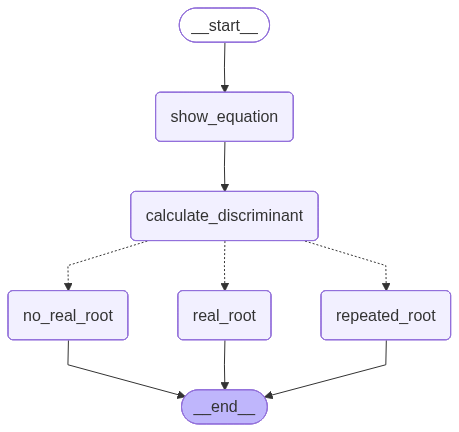

In [66]:
workflow = Graph.compile()
workflow

In [76]:
initial_state ={"a":4,"b":-5,"c":-4}
output =workflow.invoke(initial_state)
print(output["Equation"])
print(output["Discriminant"])
print(output["Result"])

4x^2 + -5x + -4
89
Two real roots:
Root 1: 1.8042476415070754
Root 2: -0.5542476415070754


# Conditional_Workflow_Using_LLM

In [3]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from pydantic import BaseModel,Field    # used for validation and structured output...
from typing import TypedDict,Literal
from dotenv import load_dotenv


In [5]:
load_dotenv()

from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)


                               # This model Support structured output

In [7]:
# will cretae the schema with the help of pydantic..
class EvaluationSchema(BaseModel):
    Sentiment:Literal["Positive","Negative"] = Field(Description ="Sentiment of the review")
    
    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15488\4047619996.py:3: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'Description'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  Sentiment:Literal["Positive","Negative"] = Field(Description ="Sentiment of the review")


In [9]:
# Will create the output parser here 
from langchain_core.output_parsers import PydanticOutputParser
parser =PydanticOutputParser(pydantic_object=EvaluationSchema)

In [63]:
format_instructions = parser.get_format_instructions()

prompt = f"""
You are a sentiment evaluation system.

Analyze the review below and classify its sentiment.

Rules:
- Sentiment must be either "Positive" or "Negative"
- Follow the output format exactly

{format_instructions}

Review:
{["review"]}
"""
response = llm.invoke(prompt)

result = parser.parse(response.content)

print(result.Sentiment)


Negative


In [13]:
class ReviewState(TypedDict):
    review:str
    Sentiment:Literal["Positive","Negative"]
    Diagnosis:dict
    Response: str

In [15]:
def find_sentiment(state: ReviewState) -> dict:
    prompt = f"""
You are a sentiment evaluation system.

Analyze the review below and classify its sentiment.

Rules:
- Sentiment must be either "Positive" or "Negative"
- Follow the output format exactly

{format_instructions}

Review:
{state["review"]}
"""

    response = llm.invoke(prompt)
    result = parser.parse(response.content)

    return {
        "Sentiment": result.Sentiment
    }


In [17]:
def check_sentiment(
    state: ReviewState
) -> Literal["Run_Diagnosis", "Positive_Response"]:
    
    if state["Sentiment"] == "Positive":
        return "Positive_Response"
    else:
        return "Run_Diagnosis"


In [19]:
def Positive_Response(state: ReviewState) -> dict:
    prompt = f"""
You are a friendly assistant.

The sentiment of the review is {state["Sentiment"]}.

Review:
{state["review"]}

Write a warm, positive, and polite response to the user based on the review.
"""

    response = llm.invoke(prompt)

    return {
        "Response": response.content
    }


In [21]:
class Schema(BaseModel):
    Issue_Type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="Category of the reported issue"
    )
    tone: Literal["Angry", "Frustrated", "Disappointed", "Calm"] = Field(
        description="Tone of the user message"
    )
    urgency: Literal["Low", "Medium", "High"] = Field(
        description="Urgency level of the issue"
    )


In [23]:
# Will create the output parser here 
from langchain_core.output_parsers import PydanticOutputParser
parser_2 =PydanticOutputParser(pydantic_object=Schema)

In [65]:
format_instructions_2 = parser_2.get_format_instructions()

prompt = f"""
You are an issue classification system.

Analyze the user review below and identify EXACTLY ONE value for each field.

Rules:
- Issue_Type: choose ONLY ONE value from [UX, Performance, Bug, Support, Other]
- tone: choose ONLY ONE value from [Angry, Frustrated, Disappointed, Calm]
- urgency: choose ONLY ONE value from [Low, Medium, High]
- Return values as STRINGS, not lists
- Follow the output format exactly
- Do NOT add explanations or extra text

{format_instructions_2}

Review:
{["review"]}
"""



response = llm.invoke(prompt)
result = parser_2.parse(response.content)

print(result.Issue_Type)
print(result.tone)
print(result.urgency)


Bug
Frustrated
High


In [27]:
def Run_Diagnosis(state: ReviewState) -> dict:
    prompt = f"""
You are an issue diagnosis system.

The user review has a NEGATIVE sentiment.

Your task:
- Diagnose the issue type
- Identify the tone of the user
- Determine the urgency level

Rules:
- Follow the output format exactly
- Do not add explanations or extra text

{format_instructions_2}

Review:
{state["review"]}
"""

    response = llm.invoke(prompt)
    result = parser_2.parse(response.content)

    return {
    "Diagnosis": result.model_dump()     # it will convert the python object into dictonary
}


In [49]:
def Negative_Response(state: ReviewState) -> dict:
    prompt = f"""
You are a customer support assistant named Bipul Kumar Jha.

The sentiment of the review is {state["Sentiment"]}.

Review:
{state["review"]}

The issue diagnosis is:
- Issue Type: {state["Diagnosis"]["Issue_Type"]}
- Tone: {state["Diagnosis"]["tone"]}
- Urgency: {state["Diagnosis"]["urgency"]}

Write a polite, empathetic, and apologetic response.
Acknowledge the issue and reassure the user that it will be addressed.
Do not be defensive.

IMPORTANT:
- End the response with:
  Bipul Kumar Jha
  Customer Support Assistant
"""
    response = llm.invoke(prompt)

    return {
        "Response": response.content
    }


In [51]:
Graph =StateGraph(ReviewState)
Graph.add_node("find_sentiment",find_sentiment)
Graph.add_node("Positive_Response",Positive_Response)
Graph.add_node("Run_Diagnosis",Run_Diagnosis)
Graph.add_node("Negative_Response",Negative_Response)

In [53]:
Graph.add_edge(START,"find_sentiment")
Graph.add_conditional_edges("find_sentiment",check_sentiment)
Graph.add_edge("Positive_Response",END)
Graph.add_edge("Run_Diagnosis","Negative_Response")
Graph.add_edge("Negative_Response",END)

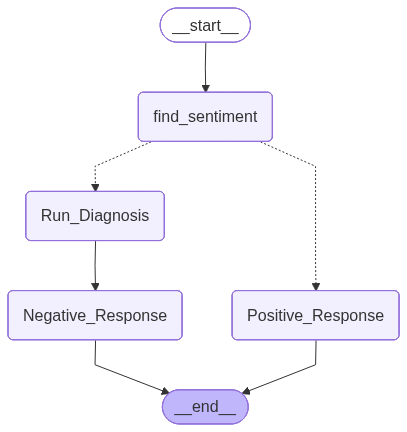

In [55]:
Workflow=Graph.compile()
Workflow

In [57]:
initial_state = {
    "review": "I really wanted to like this product, but it keeps crashing whenever I try to use it. The interface is confusing, and customer support hasn’t responded yet. This has been a frustrating experience."
}






In [59]:
final_state = Workflow.invoke(initial_state)


In [67]:
print("Review:", final_state["review"])
print("Sentiment:", final_state["Sentiment"])
print("Diagnosis:", final_state["Diagnosis"])
print("Response:", final_state["Response"])


Review: I really wanted to like this product, but it keeps crashing whenever I try to use it. The interface is confusing, and customer support hasn’t responded yet. This has been a frustrating experience.
Sentiment: Negative
Diagnosis: {'Issue_Type': 'Bug', 'tone': 'Frustrated', 'urgency': 'High'}
Response: Dear valued customer,

I'm so sorry to hear that you're experiencing issues with our product, and I can imagine how frustrating it must be for you. I want to start by apologizing for the inconvenience and distress caused by the product's crashes and confusing interface.

I understand that you've been trying to reach out to us for support, and I want to assure you that we take all concerns seriously. I'm here to help, and I'll do my best to resolve the issue as quickly as possible.

To better assist you, I'd like to request some additional information about the crashes you're experiencing. Could you please provide me with more details about the error messages you're seeing, as well a